Rohlik Group, a leading European e-grocery innovator, is revolutionising the food retail industry. We operate across 11 warehouses in Czech Republic, Germany, Austria, Hungary, and Romania.

Our challenge focuses on predicting the number of orders (grocery deliveries) at selected warehouses for the next 60 days.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train.head()

,warehouse,date,orders,holiday_name,holiday,shutdown,mini_shutdown,shops_closed,winter_school_holidays,school_holidays,blackout,mov_change,frankfurt_shutdown,precipitation,snow,user_activity_1,user_activity_2,id
0,Prague_1,2020-12-05,6895.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1722.0,32575.0,Prague_1_2020-12-05
1,Prague_1,2020-12-06,6584.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1688.0,32507.0,Prague_1_2020-12-06
2,Prague_1,2020-12-07,7030.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1696.0,32552.0,Prague_1_2020-12-07
3,Prague_1,2020-12-08,6550.0,NaN,0,0,0,0,0,0,0,0.0,0,0.8,0.0,1681.0,32423.0,Prague_1_2020-12-08
4,Prague_1,2020-12-09,6910.0,NaN,0,0,0,0,0,0,0,0.0,0,0.5,0.0,1704.0,32410.0,Prague_1_2020-12-09


In [3]:
train_calendar = pd.read_csv('train_calendar.csv')
test_calendar = pd.read_csv('test_calendar.csv')

# We will merge the train and train_calendar dataframes normally
train = pd.merge(train, train_calendar)
test = pd.merge(test, test_calendar)

train.head()

,warehouse,date,orders,holiday_name,holiday,shutdown,mini_shutdown,shops_closed,winter_school_holidays,school_holidays,blackout,mov_change,frankfurt_shutdown,precipitation,snow,user_activity_1,user_activity_2,id,warehouse_limited
0,Prague_1,2020-12-05,6895.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1722.0,32575.0,Prague_1_2020-12-05,0
1,Prague_1,2020-12-06,6584.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1688.0,32507.0,Prague_1_2020-12-06,0
2,Prague_1,2020-12-07,7030.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1696.0,32552.0,Prague_1_2020-12-07,0
3,Prague_1,2020-12-08,6550.0,NaN,0,0,0,0,0,0,0,0.0,0,0.8,0.0,1681.0,32423.0,Prague_1_2020-12-08,0
4,Prague_1,2020-12-09,6910.0,NaN,0,0,0,0,0,0,0,0.0,0,0.5,0.0,1704.0,32410.0,Prague_1_2020-12-09,0


In [4]:
train.columns

Index(['warehouse', 'date', 'orders', 'holiday_name', 'holiday', 'shutdown',
       'mini_shutdown', 'shops_closed', 'winter_school_holidays',
       'school_holidays', 'blackout', 'mov_change', 'frankfurt_shutdown',
       'precipitation', 'snow', 'user_activity_1', 'user_activity_2', 'id',
       'warehouse_limited'],
      dtype='object')

In [5]:
# Rearranging the dataframe so that the target variable is the last column and the ID is the first column
train = train[['id', 'date', 'holiday_name', 'holiday', 'shutdown',
       'mini_shutdown', 'shops_closed', 'winter_school_holidays',
       'school_holidays', 'blackout', 'mov_change', 'frankfurt_shutdown',
       'precipitation', 'snow', 'user_activity_1', 'user_activity_2', 'warehouse',
       'warehouse_limited', 'orders']]
train.head()

,id,date,holiday_name,holiday,shutdown,mini_shutdown,shops_closed,winter_school_holidays,school_holidays,blackout,mov_change,frankfurt_shutdown,precipitation,snow,user_activity_1,user_activity_2,warehouse,warehouse_limited,orders
0,Prague_1_2020-12-05,2020-12-05,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1722.0,32575.0,Prague_1,0,6895.0
1,Prague_1_2020-12-06,2020-12-06,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1688.0,32507.0,Prague_1,0,6584.0
2,Prague_1_2020-12-07,2020-12-07,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1696.0,32552.0,Prague_1,0,7030.0
3,Prague_1_2020-12-08,2020-12-08,NaN,0,0,0,0,0,0,0,0.0,0,0.8,0.0,1681.0,32423.0,Prague_1,0,6550.0
4,Prague_1_2020-12-09,2020-12-09,NaN,0,0,0,0,0,0,0,0.0,0,0.5,0.0,1704.0,32410.0,Prague_1,0,6910.0


# Data Wrangling
##1. Data Cleaning
- Remove duplicates
- Check for missing values

In [6]:
# check for missing values
def missing_values(df):
    missing = df.isnull().sum()
    missing = missing[missing > 0]
    missing.sort_values(inplace=True)
    return missing

missing_values(train)

precipitation     270
snow              270
holiday_name     7122
dtype: int64

In [7]:
missing_values(test)

holiday_name    380
dtype: int64

In [8]:
# Now we drop columns with more than 50% missing values using a threshold of 0.5
train = train.dropna(thresh=int(train.shape[0]*0.5), axis=1)
missing_values(train)

precipitation    270
snow             270
dtype: int64

In [9]:
# Now we will impute the missing values in the precipitation and snow columns with the mean of the respective columns
train['precipitation'] = train['precipitation'].fillna(train['precipitation'].mean())
train['snow'] = train['snow'].fillna(train['snow'].mean())

In [10]:
test.drop("holiday_name", axis=1)

,warehouse,date,holiday,shops_closed,winter_school_holidays,school_holidays,id
0,Prague_1,2024-03-16,0,0,0,0,Prague_1_2024-03-16
1,Prague_1,2024-03-17,0,0,0,0,Prague_1_2024-03-17
2,Prague_1,2024-03-18,0,0,0,0,Prague_1_2024-03-18
3,Prague_1,2024-03-19,0,0,0,0,Prague_1_2024-03-19
4,Prague_1,2024-03-20,0,0,0,0,Prague_1_2024-03-20
...,...,...,...,...,...,...,...
392,Budapest_1,2024-05-11,0,0,0,0,Budapest_1_2024-05-11
393,Budapest_1,2024-05-12,0,0,0,0,Budapest_1_2024-05-12
394,Budapest_1,2024-05-13,0,0,0,0,Budapest_1_2024-05-13
395,Budapest_1,2024-05-14,0,0,0,0,Budapest_1_2024-05-14


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7340 entries, 0 to 7339
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      7340 non-null   object 
 1   date                    7340 non-null   object 
 2   holiday                 7340 non-null   int64  
 3   shutdown                7340 non-null   int64  
 4   mini_shutdown           7340 non-null   int64  
 5   shops_closed            7340 non-null   int64  
 6   winter_school_holidays  7340 non-null   int64  
 7   school_holidays         7340 non-null   int64  
 8   blackout                7340 non-null   int64  
 9   mov_change              7340 non-null   float64
 10  frankfurt_shutdown      7340 non-null   int64  
 11  precipitation           7340 non-null   float64
 12  snow                    7340 non-null   float64
 13  user_activity_1         7340 non-null   float64
 14  user_activity_2         7340 non-null   

In [12]:
# Check for duplicates
train.duplicated().sum()

0

# Exploratory Data Analysis
##2. Univariate Analysis
- Distribution of the target variable
- Distribution of the features
- Outliers detection

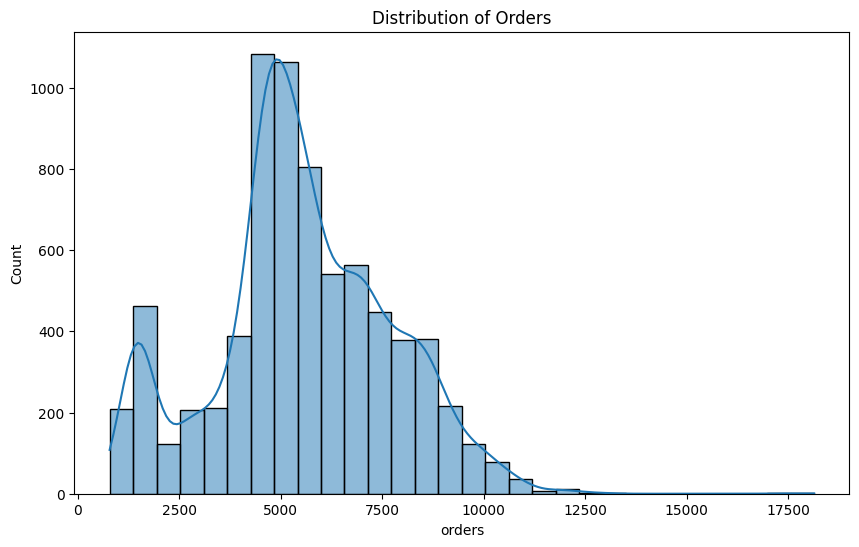

In [13]:
# Distribution of the target variable
plt.figure(figsize=(10, 6))
sns.histplot(train['orders'], kde=True, bins=30)
plt.title('Distribution of Orders')
plt.show()

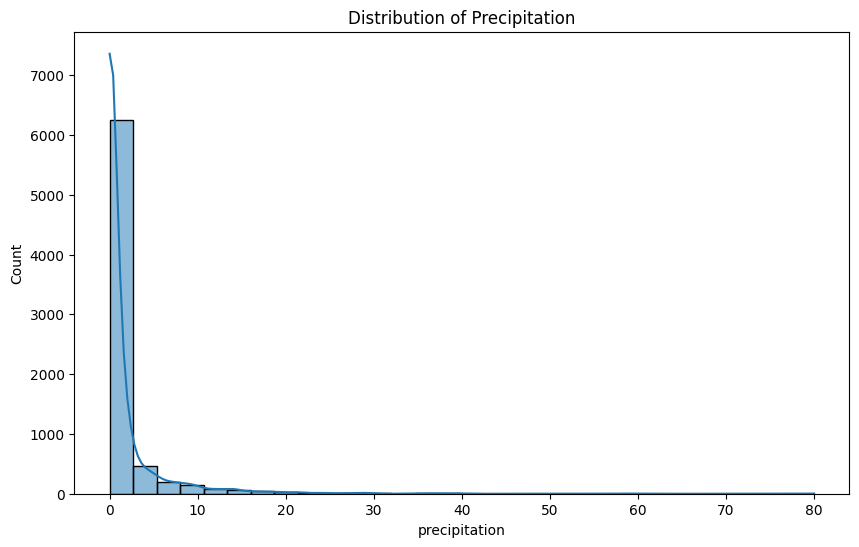

In [14]:
# Distribution of the precipitation column
plt.figure(figsize=(10, 6))
sns.histplot(train['precipitation'], kde=True, bins=30)
plt.title('Distribution of Precipitation')
plt.show()

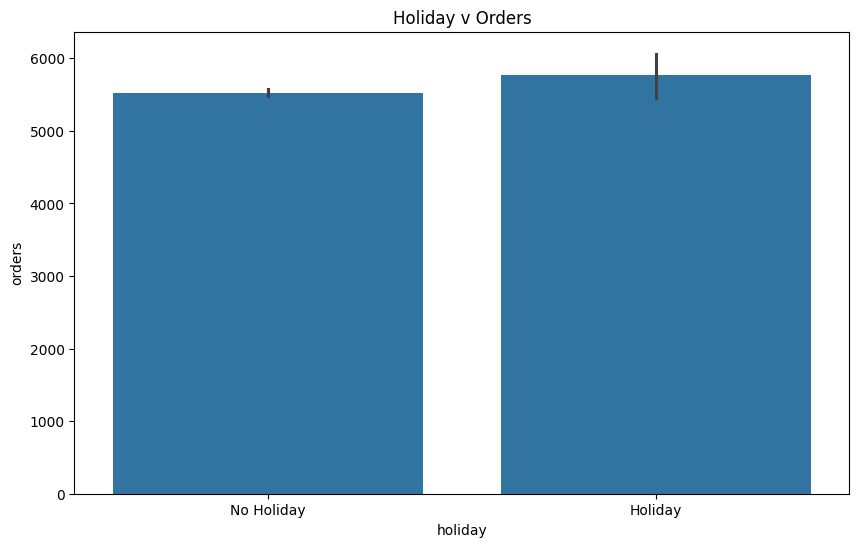

In [15]:
# Holiday v orders
plt.figure(figsize=(10, 6))
sns.barplot(x='holiday', y='orders', data=train)
plt.title('Holiday v Orders')
# replace the x-axis labels with the holiday names
plt.xticks(ticks=[0, 1], labels=['No Holiday', 'Holiday'])
plt.show()

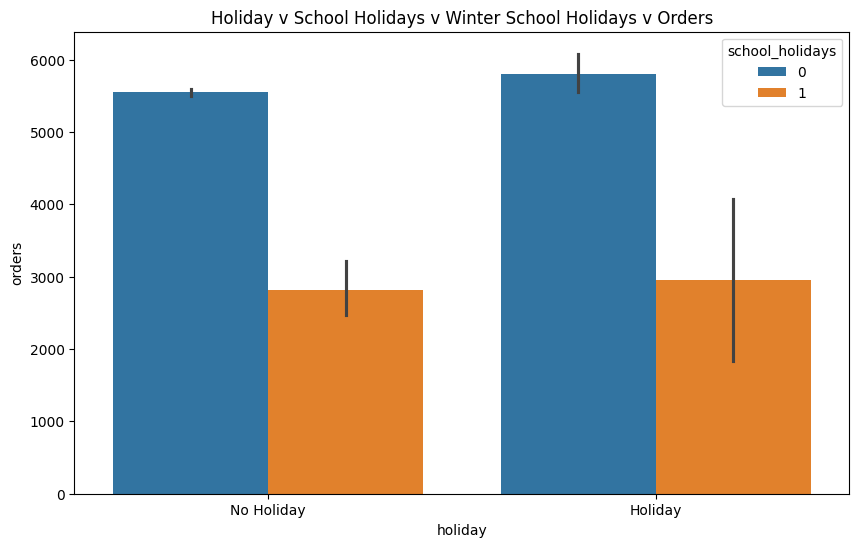

In [16]:
# Holiday v school holidays v winter school holidays v orders
plt.figure(figsize=(10, 6))
sns.barplot(x='holiday', y='orders', hue='school_holidays', data=train)
plt.title('Holiday v School Holidays v Winter School Holidays v Orders')
# replace the x-axis labels with the holiday names
plt.xticks(ticks=[0, 1], labels=['No Holiday', 'Holiday'])
plt.show();

In [17]:
train['warehouse'].unique()

array(['Prague_1', 'Brno_1', 'Prague_2', 'Prague_3', 'Munich_1',
       'Frankfurt_1', 'Budapest_1'], dtype=object)

In [18]:
# Descriptive statistics of the dataset with a background color
train.describe().style.background_gradient(cmap='viridis')

,holiday,shutdown,mini_shutdown,shops_closed,winter_school_holidays,school_holidays,blackout,mov_change,frankfurt_shutdown,precipitation,snow,user_activity_1,user_activity_2,warehouse_limited,orders
count,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000
mean,0.027248,0.000136,0.000545,0.010899,0.029973,0.007084,0.000954,0.221499,0.000272,1.621126,0.290112,1633.545777,23477.031335,0.000000,5535.443869
std,0.162816,0.011672,0.023340,0.103836,0.170524,0.083876,0.030869,0.410293,0.016506,4.458526,1.517395,784.167637,8934.848328,0.000000,2182.680279
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,482.000000,1797.000000,0.000000,790.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,945.000000,18509.000000,0.000000,4434.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1349.000000,22267.000000,0.000000,5370.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.400000,0.000000,2308.000000,30028.750000,0.000000,7009.250000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,80.000000,19.840000,3437.000000,45769.000000,0.000000,18139.000000


In [19]:
# Assuming 'train' and 'test' DataFrames are already loaded

# Feature Engineering on Training Set
train['date'] = pd.to_datetime(train['date'])
train['day_of_week'] = train['date'].dt.dayofweek
train['month'] = train['date'].dt.month
train['year'] = train['date'].dt.year
train['quarter'] = train['date'].dt.quarter
train['day'] = train['date'].dt.day
train['weekend'] = train['day_of_week'].apply(lambda x: 1 if x > 4 else 0)
train['orders_lag1'] = train['orders'].shift(1)
train['orders_diff'] = train['orders'] - train['orders_lag1']
train['orders_pct_change'] = train['orders'].pct_change()

# Drop rows with NaN values created by lag features in the training set
train = train.dropna()

# Define features and target for the training set
X_train = train.drop(['orders', 'date'], axis=1)
y_train = train['orders']

# Feature Engineering on Test Set
test['date'] = pd.to_datetime(test['date'])
test['day_of_week'] = test['date'].dt.dayofweek
test['month'] = test['date'].dt.month
test['year'] = test['date'].dt.year
test['quarter'] = test['date'].dt.quarter
test['day'] = test['date'].dt.day
test['weekend'] = test['day_of_week'].apply(lambda x: 1 if x > 4 else 0)

# Initialize lag features in the test set using the last known values from the training set
last_train_order = train['orders'].iloc[-1]
test['orders_lag1'] = last_train_order
test['orders_diff'] = 0  # No previous day to calculate difference
test['orders_pct_change'] = 0  # No previous day to calculate percentage change

In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7339 entries, 1 to 7339
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      7339 non-null   object        
 1   date                    7339 non-null   datetime64[ns]
 2   holiday                 7339 non-null   int64         
 3   shutdown                7339 non-null   int64         
 4   mini_shutdown           7339 non-null   int64         
 5   shops_closed            7339 non-null   int64         
 6   winter_school_holidays  7339 non-null   int64         
 7   school_holidays         7339 non-null   int64         
 8   blackout                7339 non-null   int64         
 9   mov_change              7339 non-null   float64       
 10  frankfurt_shutdown      7339 non-null   int64         
 11  precipitation           7339 non-null   float64       
 12  snow                    7339 non-null   float64      

In [22]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from scipy.sparse import hstack

# Define features and target for the training set
X_train = train.drop(['orders', 'date', 'id'], axis=1)
y_train = train['orders']
# Identify missing columns in the test set
missing_cols = set(X_train.columns) - set(test.columns)
for col in missing_cols:
    test[col] = 0  # or use another appropriate default value

test = test[X_train.columns]

# OneHotEncode categorical features
categorical_features = ['holiday', 'warehouse']
encoder = OneHotEncoder(handle_unknown='ignore', sparse=True)
X_train_encoded = encoder.fit_transform(X_train[categorical_features])
X_test_encoded = encoder.transform(test[categorical_features])

# Standardize the numerical features
numerical_features = X_train.drop(categorical_features, axis=1).columns
scaler = StandardScaler(with_mean=False)  # with_mean=False to work with sparse matrices
X_train_scaled = scaler.fit_transform(X_train[numerical_features])
X_test_scaled = scaler.transform(test[numerical_features])

# Combine encoded and scaled features
X_train_combined = hstack([X_train_scaled, X_train_encoded])
X_test_combined = hstack([X_test_scaled, X_test_encoded])

# Initialize and train the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_combined, y_train)

# Make predictions on the test set
predictions = model.predict(X_test_combined)

# Prepare the submission file
submission = pd.DataFrame({
    'id': test.index,  # Assuming 'id' is the index or a column in the test set
    'orders': predictions
})

# Save the submission file
submission.to_csv('submission.csv', index=False)

In [26]:
solution = pd.read_csv('solution_example.csv')
submission = pd.read_csv('submission.csv')

submission.head()

,id,orders
0,Prague_1_2024-03-16,4903.05
1,Prague_1_2024-03-17,4903.05
2,Prague_1_2024-03-18,4902.97
3,Prague_1_2024-03-19,4901.74
4,Prague_1_2024-03-20,4903.37


In [24]:
solution.head()

,id,orders
0,Prague_1_2024-03-16,5000
1,Prague_1_2024-03-17,5000
2,Prague_1_2024-03-18,5000
3,Prague_1_2024-03-19,5000
4,Prague_1_2024-03-20,5000


In [25]:
# Prepare the submission file based on the sample submission
submission = solution.copy()
submission['orders'] = predictions

# Save the submission file
submission.to_csv('submission.csv', index=False)